In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
from HighLevelFeatures import HighLevelFeatures as HLF
import numpy as np
import h5py
import matplotlib.pyplot as plt
from model import WGANGP
from train import *
from common import *
from evaluate import *
from common import _split_energy


2023-10-07 00:02:23.300125: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-07 00:02:23.300144: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Plot statistics

In [4]:
# photon_file = h5py.File(f'{input_path}/dataset_1_photons_1.hdf5', 'r')
# pion_file = h5py.File(f'{input_path}/dataset_1_pions_1.hdf5', 'r')

photon_file = h5py.File(f'../output/dataset1/v1/splitJuly/gan_3energy_split.h5', 'r')
pion_file = h5py.File(f'../output/dataset1/v1/splitJuly/gan_2energy_split.h5', 'r')

energies1 = photon_file['incident_energies'][:]/1000
energies2 = pion_file['incident_energies'][:]/1000


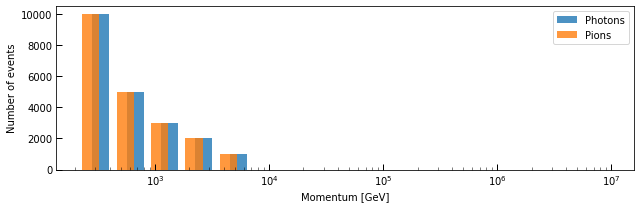

In [5]:
bins = np.logspace(8,23,31, base=2)
fig, ax = plt.subplots(figsize=(9, 3))
plt.hist(energies1*1.1, bins=bins*1.1, alpha=0.8, label='Photons')
plt.hist(energies2*0.9, bins=bins*0.9, alpha=0.8, label='Pions')
plt.xscale('log')
plt.xlabel('Momentum [GeV]')
plt.ylabel('Number of events')
plt.tick_params(axis="both", which="major", width=1, length=6, labelsize=10, direction="in")
plt.tick_params(axis="both", which="minor", width=0.5, length=3, labelsize=10, direction="in")
plt.legend()
plt.tight_layout()
plt.savefig('statistics.pdf')
plt.show()

## Validate h5 file generated from best model

In [5]:
input_data = h5py.File(f'../input/dataset1/dataset_1_pions_1.hdf5', 'r')
input_incident = input_data['incident_energies'][:]
input_shower = input_data['showers'][:]

In [6]:
# output_data = h5py.File(f'../output/dataset1/v2/BNswish_hpo4-M1/photons_eta_20_25/selected/h5/gan.h5', 'r')
output_data = h5py.File(f'../output/dataset1/v1/BNReLUCustActiv_hpo27-M-Pnormlayer2.2/pions_eta_20_25/selected/h5/gan.h5', 'r')
# output_data = h5py.File(f'../output/dataset1/v1/BNswish_hpo101-M-P-L-Sge12/photons_eta_20_25/selected/h5/gan.h5', 'r')
# output_data = h5py.File(f'../output/dataset1/v1/splitJuly/gan_2energy_split.h5', 'r')
# output_data = h5py.File(f'../output/dataset1/v1/splitJuly/gan_3energy_split.h5', 'r')

output_incident = output_data['incident_energies'][:]
output_shower = output_data['showers'][:]

In [7]:
input_shower.shape, output_shower.shape

((120800, 533), (120800, 533))

In [8]:
input_shower_small = input_shower[input_incident.flatten() == 4194304]
output_shower_small = output_shower[output_incident.flatten() == 4194304]
input_shower_small.shape, output_shower_small.shape

((1000, 533), (1000, 533))

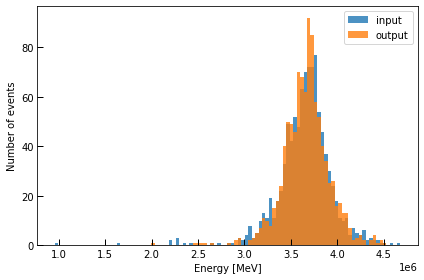

In [9]:
# bins = np.logspace(8,23,31, base=2)
n, bins, _ = plt.hist(input_shower_small.sum(axis=1), bins=100, alpha=0.8, label='input')
plt.hist(output_shower_small.sum(axis=1), bins=bins, alpha=0.8, label='output')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Number of events')
plt.tick_params(axis="both", which="major", width=1, length=6, labelsize=10, direction="in")
plt.tick_params(axis="both", which="minor", width=0.5, length=3, labelsize=10, direction="in")
plt.legend()
plt.tight_layout()
plt.show()

## Merge splitted energy

In [3]:
def merge_dataset(keep_incident, keep_shower, remove_incident, remove_shower):
    common = np.intersect1d(np.unique(keep_incident), np.unique(remove_incident))
    remove_shower_new = remove_shower[remove_incident.flatten() != common]
    remove_incident_new = remove_incident[remove_incident.flatten() != common]
    if remove_incident_new.shape[0] == 1:
        remove_incident_new = remove_incident_new[0]
        remove_shower_new = remove_shower_new[0]
    return np.concatenate((keep_incident, remove_incident_new)), np.concatenate((keep_shower, remove_shower_new))

def gen_h5(energies, showers, output):
    os.makedirs(os.path.dirname(output), exist_ok=True)
    dataset_file = h5py.File(output, 'w')
    energies = np.array(energies)
    showers  = np.array(showers)
    dataset_file.create_dataset('incident_energies', data=energies.reshape(len(energies), -1), compression='gzip')
    dataset_file.create_dataset('showers', data=showers.reshape(len(showers), -1), compression='gzip')
    print('Save h5 file to', output)
    dataset_file.close()

In [4]:
#output_data1 = h5py.File(f'../output/dataset1/v1/BNLeakyReLU_hpo31-M-P-L-Sle12.3/photons_eta_20_25/selected/h5/gan.h5', 'r')
#output_data2 = h5py.File(f'../output/dataset1/v1/BNswish_hpo101-M-P-L-Sge12/photons_eta_20_25/selected/h5/gan.h5', 'r')
#output_data3 = h5py.File(f'../output/dataset1/v1/BNswish_hpo101-M-P-L-Sge12le18.2/photons_eta_20_25/selected/h5/gan.h5', 'r')
#output_data4 = h5py.File(f'../output/dataset1/v1/BNswish_hpo101-M-P-L-Sge18/photons_eta_20_25/selected/h5/gan.h5', 'r')
low12 = f'../output/dataset1/v1/BNswishCustActiv_hpo113-M-Pnormlayer2-L-Sle12.1/photons_eta_20_25/selected/h5/gan.h5'
high12 = f'../output/dataset1/v1/BNswishCustActiv_hpo113-M-Pnormlayer2-L-Sge12/photons_eta_20_25/selected/h5/gan.h5'
high12low18 = f'../output/dataset1/v1/BNswishCustActiv_hpo113-M-Pnormlayer2-L-ge12le18.1/photons_eta_20_25/selected/h5/gan.h5'
high18 = f'../output/dataset1/v1/BNswishCustMichele_hpo117-M-PnormlayerMichele-L-ge18.Michele/photons_eta_20_25/selected/h5/gan.h5'
output_data1 = h5py.File(low12, 'r')
output_data2 = h5py.File(high12, 'r')
output_data3 = h5py.File(high12low18, 'r')
output_data4 = h5py.File(high18, 'r')
output = '../output/dataset1/v1/splitJuly/'

###########  1      2       3         4
###########  le12   ge12    ge12le18  g18
## 4.1 MeV   1.9    2.2     2.1
## 262.1GeV                 2.5       2.0

keep_incident = output_data2['incident_energies'][:]
keep_shower = output_data2['showers'][:]
remove_incident = output_data1['incident_energies'][:]
remove_shower = output_data1['showers'][:]
energies, showers = merge_dataset(keep_incident, keep_shower, remove_incident, remove_shower)
gen_h5(energies, showers, os.path.join(output, 'gan_2energy_split.h5'))



Save h5 file to ../output/dataset1/v1/splitJuly/gan_2energy_split.h5


In [22]:
keep_incident = output_data3['incident_energies'][:]
keep_shower = output_data3['showers'][:]
remove_incident = output_data1['incident_energies'][:]
remove_shower = output_data1['showers'][:]
remove2_incident, remove2_shower = merge_dataset(keep_incident, keep_shower, remove_incident, remove_shower)

keep2_incident = output_data4['incident_energies'][:]
keep2_shower = output_data4['showers'][:]
remove3_incident, remove3_shower = merge_dataset(keep2_incident, keep2_shower, remove2_incident, remove2_shower)

gen_h5(remove3_incident, remove3_shower, os.path.join(output, 'gan_3energy_split.h5'))



Save h5 file to ../output/dataset1/v1/splitJuly/gan_3energy_split.h5


In [18]:
keep2_incident.shape, keep2_shower.shape, remove2_incident.shape, remove2_shower.shape

((21000, 1), (21000, 368), (121000, 1), (121000, 368))

In [24]:
gan2 = f'../output/dataset1/v1/splitJuly/gan_2energy_split.h5'
gan3 = f'../output/dataset1/v1/splitJuly/gan_3energy_split.h5'
output_gan2 = h5py.File(gan2, 'r')
output_gan3 = h5py.File(gan3, 'r')

In [25]:
output_gan2['incident_energies'][2], output_gan2['showers'][2]


(array([1048576.]),
 array([  857.62744   ,   136.8528    ,   170.02324   ,    71.243256  ,
          197.43582   ,   224.03748   ,   315.17368   ,     9.546662  ,
         3599.2507    ,  1522.3857    ,   520.9956    ,   482.87634   ,
          361.36594   ,   182.48288   ,   237.29      ,   301.8787    ,
           70.73656   ,   123.82303   ,    43.554688  ,    55.57307   ,
           20.634867  ,    31.862736  ,    15.229047  ,     8.086292  ,
         3367.6897    ,  1006.9653    ,   696.0273    ,   604.285     ,
          420.91275   ,   270.49405   ,   240.81389   ,   275.87827   ,
           87.13384   ,   121.127754  ,    46.03906   ,    80.67387   ,
            8.318858  ,     7.158717  ,    17.29661   ,    10.950831  ,
         4349.0645    ,  1082.5897    ,   813.2533    ,   582.7933    ,
          447.50778   ,   280.0273    ,   269.6241    ,   203.35162   ,
          150.1346    ,   115.695724  ,    15.845     ,    13.484341  ,
           87.0815    ,    22.083788  ,    1

In [26]:
output_gan3['incident_energies'][2], output_gan3['showers'][2]


(array([262144.]),
 array([  212.91757   ,     0.00097337,     0.00187234,     3.4308352 ,
           13.408962  ,    23.63064   ,     1.9980791 ,     3.5197952 ,
         1324.3192    ,   194.69551   ,    63.443104  ,   135.3466    ,
           69.21023   ,    43.677433  ,    33.75696   ,    36.92214   ,
            9.17078   ,     9.9337435 ,    13.645475  ,     4.882561  ,
            1.4947007 ,     0.6846124 ,     0.12965833,     3.0969324 ,
          733.5206    ,   280.50354   ,   211.30919   ,    75.15857   ,
          100.24838   ,    74.78077   ,    63.81709   ,    78.26654   ,
           27.371994  ,    37.37782   ,     1.6785845 ,     0.16825712,
            0.80785453,    36.675163  ,    11.520609  ,     0.1622596 ,
          575.02185   ,   435.55618   ,   223.74971   ,   122.15301   ,
           85.86265   ,    84.84292   ,   101.21454   ,    71.37649   ,
           18.308435  ,    17.485565  ,    28.369493  ,     7.260755  ,
            2.1723182 ,     3.166068  ,     3

In [15]:
output_gan2['incident_energies'][:20]

array([[  16384.],
       [ 524288.],
       [1048576.],
       [  16384.],
       [   8192.],
       [  65536.],
       [   8192.],
       [  32768.],
       [ 262144.],
       [   4096.],
       [ 131072.],
       [ 131072.],
       [  65536.],
       [ 262144.],
       [ 131072.],
       [  65536.],
       [  65536.],
       [ 131072.],
       [ 524288.],
       [   4096.]])

In [20]:
output_gan2.close()

In [21]:
output_gan3.close()